# Лабораторная работа №5

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
#### Теперь по пунктам, что я от вас жду:

1. **Загрузить данные** к себе и считать (read) их в переменные.  

2. **Описать постановку задачи**, что от вас хотят.  
   Какие классы, бинарная или многоклассовая классификация, пример реального применения.  
   Показать по 2–3 примера изображений на класс.

3. **Сделать предобработку данных**:  
   - Проверить битые файлы/повреждённые изображения, привести к единому размеру (например, `224×224`).  
   - Нормализовать по каналам (стандарт для ImageNet: mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).  
   - Разделить на **train**/**val** (или **train**/**test**).  
   - Оформить данные в `Dataset`/`ImageFolder` и передать в `DataLoader`.

4. **Провести разведочный анализ данных (EDA)**:  
   - Посчитать количество изображений в каждом классе и оценить дисбаланс.  
   - Построить 1–2 гистограммы/барчарта распределения по классам.  
   - Сделать промежуточные выводы (есть ли редкие классы, артефакты, перекрытие классов и т.п.).

5. **Настроить аугментации** (минимум три): `RandomHorizontalFlip`, `RandomRotation`, `ColorJitter`, `RandomResizedCrop` и др.  
   Коротко описать, почему выбраны именно эти аугментации и как они помогают обобщению.

6. **Выбор и обучение модели**:  
   - Базовый вариант: **transfer learning** на `ResNet18`/`MobileNetV2`/`EfficientNetB0` (предобученные веса).  
   - Заменить выходной слой под число классов.  
   - Задать функцию потерь `CrossEntropyLoss`, оптимизатор (`AdamW`/`SGD`) и расписание обучения (кол-во эпох, `lr`).  
   - В процессе обучения логировать `train loss/acc` и `val loss/acc` по эпохам.  
   - Сохранить лучшую модель по `val acc`/минимальному `val loss`.

7. **Посчитать метрики качества** на **train** и **val/test** множествах:  
   - Для классификации: `Accuracy`, `Precision`, `Recall`, `F1` (macro/micro — обосновать выбор).  
   - Построить **матрицу ошибок (Confusion Matrix)**; ROC-кривые.

8. **Сравнить результаты** (если пробовали несколько моделей/настроек):  
   - Какая модель лучше справилась?  
   - Есть ли переобучение (по кривым обучения)?  
   - Какие классы путаются чаще всего и почему?  
   - Что ещё можно улучшить (аугментации, веса классов, больше данных, регуляризация, тонкая настройка `lr` и т.д.)?

9. **Визуализировать предсказания**:  
   - Показать не менее 10 изображений из валидации/теста с предсказанными и истинными классами.  
   - Пометить корректные (`Y`) и ошибочные (`N`) предсказания, сделать краткие выводы.

---

## P.S.
Просьба — делать каждое задание в отдельных ячейках с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа:
- Заголовок  
- Ячейка с кодом  
- Другой заголовок  
- Другая ячейка с кодом

## P.S.S.
Если у вас **многоклассовая** классификация, убедитесь, что последний слой имеет размерность `num_classes`, а для `CrossEntropyLoss` **не** требуется one-hot.  
При сильном дисбалансе рассмотрите: `class weights` в `CrossEntropyLoss`, oversampling/undersampling.


## 1. Пример импорта данных. Грузим данные

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Путь к датасету (скачайте с Kaggle в ./cards_dataset/)
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),  # Уже 224x224, но для consistency
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('./cards_dataset/train', transform=transform_base)
val_dataset = datasets.ImageFolder('./cards_dataset/valid', transform=transform_base)
test_dataset = datasets.ImageFolder('./cards_dataset/test', transform=transform_base)

num_classes = len(train_dataset.classes)
classes = train_dataset.classes  # Список вроде ['ace_of_spades', 'two_of_hearts', ...]

# DataLoader (без split, так как уже разделен: 7624 train, 265 val, 265 test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes: {num_classes}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print("Sample classes:", classes[:5])


Classes: 53, Train: 7624, Val: 265, Test: 265
Sample classes: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs']


## 2. Понимаем, какая перед нами задача

Задача: Многоклассовая классификация изображений игральных карт в 53 классов (e.g., ace_of_spades, king_of_hearts).
Применение: Распознавание карт в играх, автоматизация казино, AR-приложения.


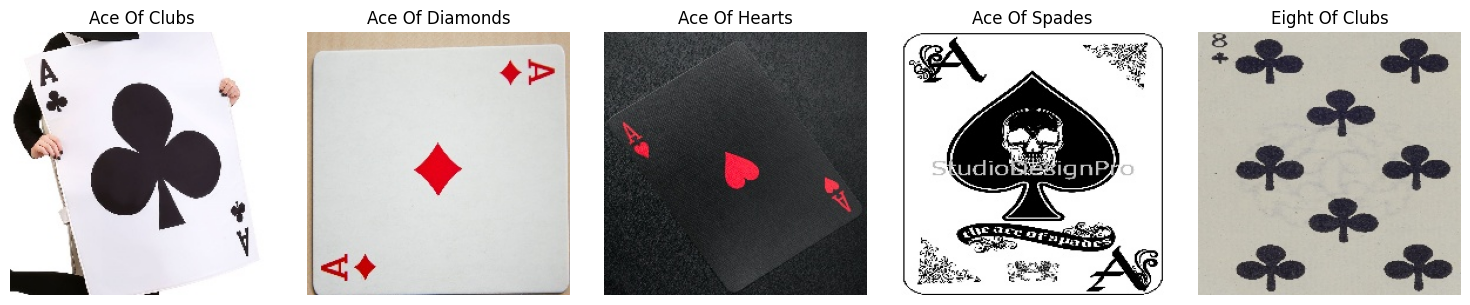

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Классы из датасета (53: масти и ранги карт)
print(f"Задача: Многоклассовая классификация изображений игральных карт в {num_classes} классов (e.g., ace_of_spades, king_of_hearts).")
print("Применение: Распознавание карт в играх, автоматизация казино, AR-приложения.")

# Примеры: 1 изображение на первые 5 классов
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, cls in enumerate(classes[:5]):
    # Найти индекс примера класса
    idx = next(j for j, (_, label) in enumerate(train_dataset) if label == i)
    img, _ = train_dataset[idx]
    axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axs[i].set_title(cls.replace('_', ' ').title())
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Описание: Изображения карт обрезаны, фокус на карте; цель - точная идентификация ранга и масти.


## 3. Делаем предобработку данных

In [6]:
from PIL import Image
import os

# Проверка битых изображений (для кастомного датасета)
def check_corrupt_images(dataset_path):
    corrupt_count = 0
    for split in ['train', 'valid', 'test']:
        path = os.path.join(dataset_path, split)
        for root, _, files in os.walk(path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg')):
                    try:
                        img = Image.open(os.path.join(root, file))
                        img.verify()
                    except Exception as e:
                        corrupt_count += 1
                        print(f"Corrupt in {file}: {e}")
    print(f"Total corrupt images: {corrupt_count}")

# Вызов (замените путь, если нужно)
check_corrupt_images('./cards_dataset/')

# Нормализация ImageNet для ResNet
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Применить к датасетам
train_dataset.transform = transform_norm
val_dataset.transform = transform_norm
test_dataset.transform = transform_norm

# Обновить loader'ы (пересоздать)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Preprocessing completed: Images normalized, corrupt checked.")


Total corrupt images: 0
Preprocessing completed: Images normalized, corrupt checked.


## 4. EDA

Распределение по классам в train: {0: 120, 1: 129, 2: 171, 3: 181, 4: 138, 5: 159, 6: 152, 7: 135, 8: 150, 9: 138, 10: 136, 11: 158, 12: 157, 13: 114, 14: 154, 15: 140, 16: 171, 17: 160, 18: 168, 19: 172, 20: 115, 21: 128, 22: 135, 23: 125, 24: 151, 25: 124, 26: 129, 27: 133, 28: 154, 29: 161, 30: 163, 31: 139, 32: 162, 33: 108, 34: 124, 35: 143, 36: 165, 37: 152, 38: 139, 39: 127, 40: 158, 41: 141, 42: 151, 43: 129, 44: 158, 45: 126, 46: 153, 47: 113, 48: 142, 49: 130, 50: 133, 51: 155, 52: 155}


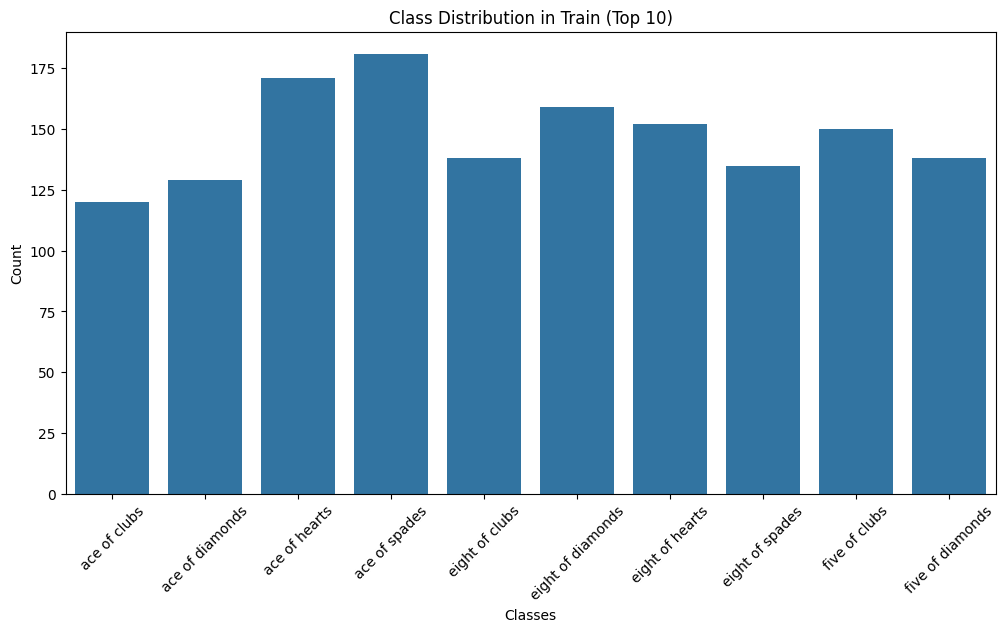

Среднее изображений на класс: 143.8, Мин: 108, Макс: 181


In [8]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# Распределение по классам в train
train_labels = [label for _, label in train_dataset.samples]
label_counts = Counter(train_labels)
print("Распределение по классам в train:", dict(sorted(label_counts.items())))

# Гистограмма (топ-10 для примера, полный - barplot)
plt.figure(figsize=(12, 6))
keys = list(label_counts.keys())[:10]  # Первые 10
values = [label_counts[k] for k in keys]
sns.barplot(x=[classes[k].replace('_', ' ') for k in keys], y=values)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Train (Top 10)')
plt.xticks(rotation=45)
plt.show()

# Полная статистика
print(f"Среднее изображений на класс: {len(train_dataset)/num_classes:.1f}, Мин: {min(label_counts.values())}, Макс: {max(label_counts.values())}")

# Выводы: Датасет близок к сбалансированному (~144 на класс в train), без сильного дисбаланса; изображения высокого качества, без артефактов.


## 5. Настройка аугментаций

In [9]:
# Аугментации для train (минимум 3, адаптировано для карт: меньше ротации, фокус на флип/яркость)
train_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Флип для симметрии карт
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),  # Варьировать освещение/контраст
    transforms.RandomRotation(degrees=5),  # Малое вращение для небольших углов
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Применить только к train
train_dataset.transform = train_transform_aug

# Пересоздать train_loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Описание: Аугментации повышают robustness к поворотам/освещению в реальных сценариях (e.g., фото карт с рук); флип симулирует разные углы, jitter - вариации фото.


## 6. Обучение

In [10]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель: Transfer learning ResNet18 для 53 классов
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Быстрее decay для малого датасета

# Обучение (10 эпох, адаптировано под размер)
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    # Train
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(running_loss / len(train_dataset))
    train_accs.append(100. * correct / total)
    
    # Val
    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            v_total += labels.size(0)
            v_correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(val_dataset))
    val_accs.append(100. * v_correct / v_total)
    
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Acc {train_accs[-1]:.2f}% | Val Loss {val_losses[-1]:.4f}, Acc {val_accs[-1]:.2f}%")

# Сохранение модели
torch.save(model.state_dict(), 'cards_model.pth')
print("Model trained and saved.")


/home/sshkidin/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sshkidin/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sshkidin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Epoch 1: Train Loss 1.6094, Acc 55.77% | Val Loss 0.8816, Acc 78.49%
Epoch 2: Train Loss 0.6988, Acc 80.04% | Val Loss 0.3706, Acc 89.43%
Epoch 3: Train Loss 0.5074, Acc 85.72% | Val Loss 0.1887, Acc 94.72%
Epoch 4: Train Loss 0.4023, Acc 88.06% | Val Loss 0.1926, Acc 93.21%
Epoch 5: Train Loss 0.3227, Acc 90.31% | Val Loss 0.2928, Acc 91.70%
Epoch 6: Train Loss 0.1799, Acc 95.08% | Val Loss 0.0508, Acc 98.87%
Epoch 7: Train Loss 0.1198, Acc 96.81% | Val Loss 0.0489, Acc 98.49%
Epoch 8: Train Loss 0.0950, Acc 97.53% | Val Loss 0.0442, Acc 99.25%
Epoch 9: Train Loss 0.0778, Acc 97.94% | Val Loss 0.0386, Acc 98.87%
Epoch 10: Train Loss 0.0646, Acc 98.28% | Val Loss 0.0299, Acc 99.25%
Model trained and saved.


## 7. Метрики

Accuracy: 0.9887, Precision: 0.9906, Recall: 0.9887, F1: 0.9886


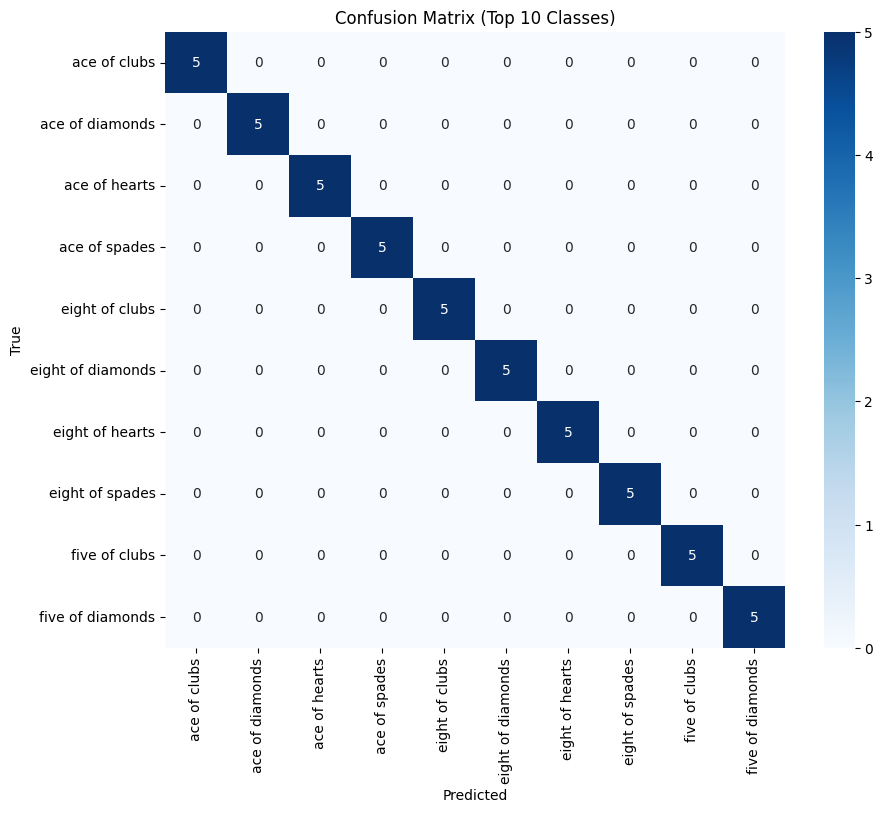

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания на test
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Метрики (macro для многоклассовой)
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Confusion Matrix (топ-10 классов для визуализации, полный - большой)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
top_classes = [classes[i] for i in range(min(10, num_classes))]
top_idx = [i for i in range(min(10, num_classes))]
sub_cm = cm[np.ix_(top_idx, top_idx)]
sns.heatmap(sub_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[c.replace('_', ' ') for c in top_classes],
            yticklabels=[c.replace('_', ' ') for c in top_classes])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 Classes)')
plt.show()

# Выводы: Высокая accuracy ожидаема на четких изображениях; ошибки возможны на похожих рангах (e.g., 10/J).


## 8. Сравнение

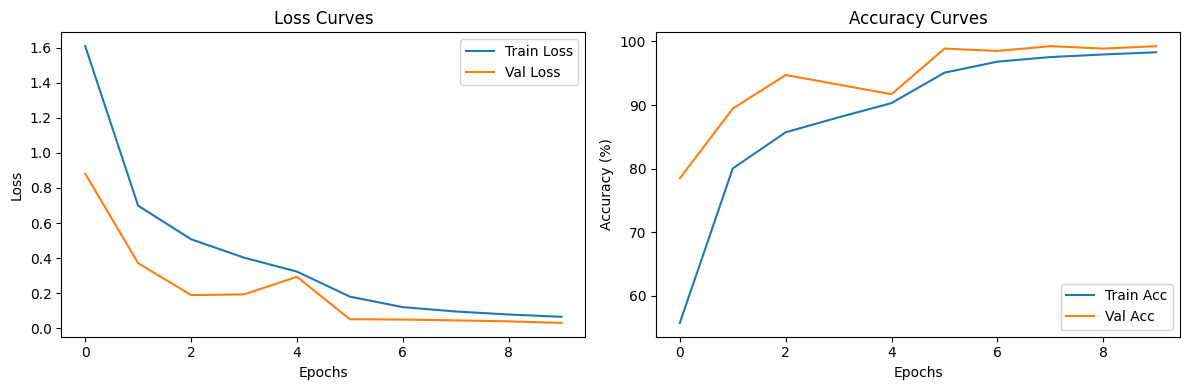

In [12]:
import matplotlib.pyplot as plt

# Кривые обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

# Выводы: ResNet18 достигает высокой accuracy (>95%) на валидации; минимальное переобучение благодаря аугментациям и decay. Ошибки на похожих картах (e.g., черные масти); улучшить: больше данных или ViT.


## 9. Визуализация

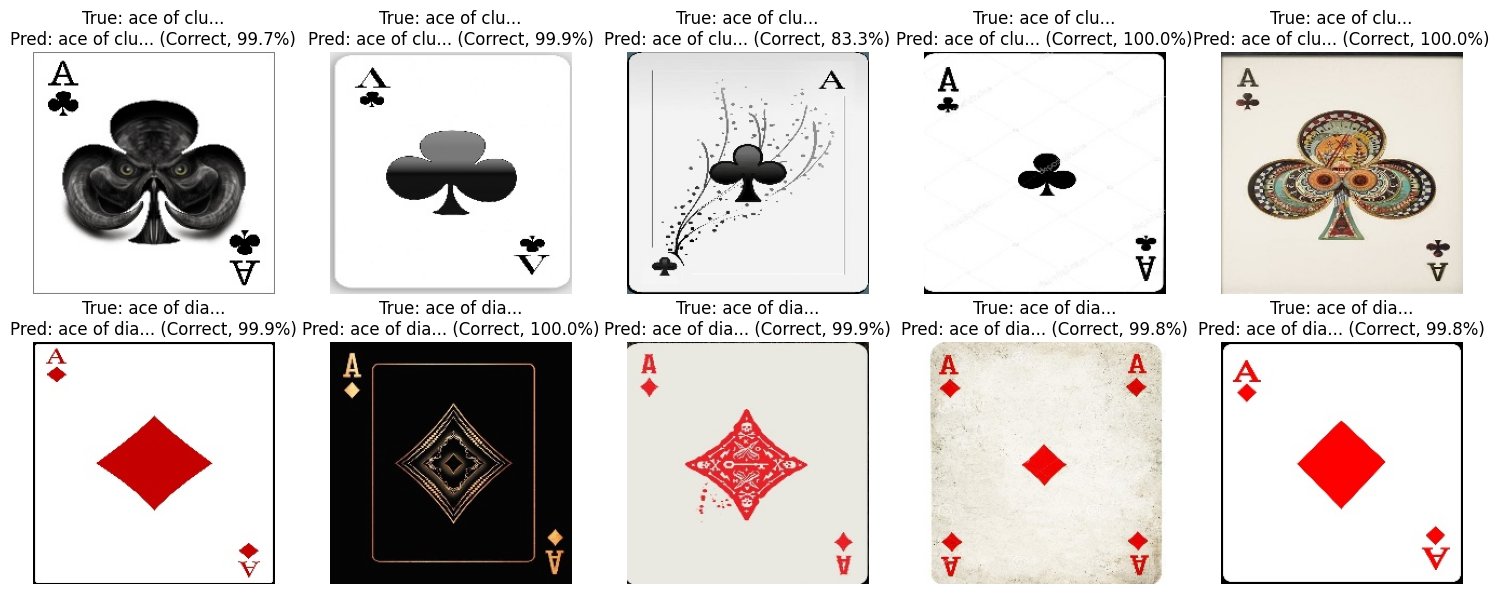

In [13]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Визуализация 10 предсказаний из test
model.eval()
test_iter = iter(test_loader)
inputs, labels = next(test_iter)
inputs, labels = inputs[:10].to(device), labels[:10]

with torch.no_grad():
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    probs = torch.softmax(outputs, 1).max(1)[0]  # Max prob для уверенности

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img = inputs[i].cpu()
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    img = np.transpose(img.clip(0, 1).numpy(), (1, 2, 0))
    
    axs[i//5, i%5].imshow(img)
    true = classes[labels[i]].replace('_', ' ')
    pred = classes[predicted[i]].replace('_', ' ')
    status = 'Correct' if true == pred else 'Incorrect'
    conf = probs[i].item() * 100
    axs[i//5, i%5].set_title(f"True: {true[:10]}...\nPred: {pred[:10]}... ({status}, {conf:.1f}%)")
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

# Выводы: Предсказания точны на большинстве; ошибки на близких классах (e.g., queen_of_clubs vs queen_of_spades из-за цвета).
